In [31]:
import os
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers.experimental import preprocessing
from json import load
import numpy as np

# Unzipping the dataset
zip_file_path = '/content/segmentation_project_data.zip'
destination_folder = '/content/segmentation_project_data'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(destination_folder)

## Create training, validation, test sets

The training, validation, and test folders contain sets of T1, T2, mask images for each subject. Create separate dataset objects from these folders.

The dataset objects emit (x,y) tuples where x is a 240x240x2 array containing the T1 and T2 images in that order, and y is a 240x240x3 array containing binary images for the background, T1 contrast enhancing, and T2 abnormality masks in that order.


In [32]:
def dataset(folder, extension=".png"):
    """Create a dataset object from a folder containing masks, t1, and t2 images.

    The dataset is an iterator that emits (x,y) tuples with the form:

    x - an M x N x 2 array containing the t1 and t2 images in channels 1,2 respectively
    y - an M x N x 3 array containing the masks for background, contrast enhancement,
        and t2 abnormality in channels 1, 2, and 3 respectively.
    """

    # generate 3-tuples of t1, t2, mask for each subject
    files = [f for f in os.listdir(folder) if os.path.splitext(f)[1] == extension]
    subjects = set([f.split("_")[0] for f in files])
    triplets = []
    for s in subjects:
        if (os.path.isfile(os.path.join(folder, f"{s}_t1{extension}"))
            and os.path.isfile(os.path.join(folder, f"{s}_t2{extension}"))
            and os.path.isfile(os.path.join(folder, f"{s}_mask{extension}"))
        ):
            triplets.append(
                (os.path.join(folder, f"{s}_t1{extension}"),
                 os.path.join(folder, f"{s}_t2{extension}"),
                 os.path.join(folder, f"{s}_mask{extension}"))
            )

    # create a dataset - map read, decode, and stack operation to create a
    # 2-channel input x (t1, t2) and a 3-channel label y (0, t1+, t2+)
    def read_decode(x):
        return tf.io.decode_image(tf.io.read_file(x))
    def mask(x):
        return tf.cast(tf.concat([tf.equal(x,0), tf.equal(x,1), tf.equal(x,2)], axis=2), tf.float32)
    ds = tf.data.Dataset.from_tensor_slices(triplets)
    ds = ds.map(lambda x: (read_decode(x[0]), read_decode(x[1]), read_decode(x[2])))
    ds = ds.map(lambda x,y,z: (tf.concat([x,y],axis=2), mask(z)))
    ds = ds.map(lambda x,y: (tf.cast(x, tf.float32), tf.cast(y, tf.float32)))
    ds = ds.map(lambda x,y: (tf.ensure_shape(x, [240, 240, 2]), tf.ensure_shape(y, [240, 240, 3])))
    return ds


## Class weights and normalization data

The base folder has JSON files containing the total pixel counts for each class (class_weights.json) and mean and variance statistics for the images (normalization.json).

Since the classes are highly imbalanced, we use class weights to encourage the optimization to focus more on the less common classes of T1 contrast enhancement and T2 abnormality. These weights are calculated as the inverse prevalance for each class.

The normalization contains mean and variance statistics for the T1 and T2 channels of the input. These are used to shift and scale the network inputs.

In [33]:
def load_class_weights(file):
    """Load class counts and calculate class weights."""

    with open(file) as f:
        class_weights = load(f)
    class_weights = np.array([v for v in class_weights.values()])
    class_weights = np.sum(class_weights) / class_weights

    return class_weights


def load_normalization(file):
    """Load normalization statistics."""

    with open(file) as f:
        statistics = load(f)
    mu = [statistics["t1_mu"], statistics["t2_mu"]]
    sigma = [statistics["t1_sigma"], statistics["t2_sigma"]]

    return mu, sigma

In [34]:
data_augmentation = tf.keras.Sequential([
    preprocessing.RandomFlip("horizontal")
])

## Create a U-Net like network

The network you will implement is similar to U-Net where the upconvolutions have been replaced with simple upsampling layers (tf.keras.layers.UpSampling2D or torch.nn.Upsample in PyTorch).


In [35]:
from tensorflow.keras import Model
from tensorflow.keras.activations import softmax
from tensorflow.keras.layers import (
    concatenate, Conv2D, Dense, Input, Lambda, MaxPooling2D, UpSampling2D
)
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import IoU
from tensorflow import constant

# define a block of convolutions for each step in the U-net
def conv_block(x, filters, name, layers=2, kernel_size=3, activation="relu"):
    for layer in range(layers):
        x = Conv2D(
            filters=filters,
            kernel_size=kernel_size,
            activation=activation,
            padding="same",
            name=f"{name}_{layer}"
            )(x)
    return x

# input channel - we feed in a 2-channel image containing t1, t2 channels
xi = Input((240, 240, 2), dtype=tf.float32)

# normalize on GPU for additional speed
mu, sigma = load_normalization('/content/segmentation_project_data/segmentation_project_data/normalization.json')
mu = constant([[[list(mu)]]], dtype=tf.float32)
sigma = constant([[[list(sigma)]]], dtype=tf.float32)
xn = Lambda(lambda x: (x-mu)/sigma)(xi)

# Apply data augmentation
xaug = data_augmentation(xn)


################################################################################
# Contracting Path
c1 = conv_block(xaug, 16, "c1")
p1 = MaxPooling2D(pool_size=(2, 2))(c1)

c2 = conv_block(p1, 32, "c2")
p2 = MaxPooling2D(pool_size=(2, 2))(c2)

c3 = conv_block(p2, 64, "c3")
p3 = MaxPooling2D(pool_size=(2, 2))(c3)

c4 = conv_block(p3, 128, "c4")
p4 = MaxPooling2D(pool_size=(2, 2))(c4)

# Bottleneck
b = conv_block(p4, 256, "b")

# Expansive Path
u1 = UpSampling2D(size=(2, 2))(b)
concat1 = concatenate([u1, c4])
c5 = conv_block(concat1, 512, "c5")

u2 = UpSampling2D(size=(2, 2))(c5)
concat2 = concatenate([u2, c3])
c6 = conv_block(concat2, 256, "c6")

u3 = UpSampling2D(size=(2, 2))(c6)
concat3 = concatenate([u3, c2])
c7 = conv_block(concat3, 128, "c7")

u4 = UpSampling2D(size=(2, 2))(c7)
concat4 = concatenate([u4, c1])
c8 = conv_block(concat4, 64, "c8")

# Output layer: Use softmax for multi-class segmentation.
output = Conv2D(3, (1, 1), activation="softmax")(c8)

################################################################################

# load class weights
class_weights = load_class_weights('/content/segmentation_project_data/segmentation_project_data/class_weights.json')

# create and compile a model
model = Model(inputs=[xi], outputs=[output])
model.compile(
    loss=CategoricalCrossentropy(),
    loss_weights=list(class_weights),
    metrics=[
        IoU(3, target_class_ids=[1], sparse_y_true=False, sparse_y_pred=False, name="t1_iou"),
        IoU(3, target_class_ids=[2], sparse_y_true=False, sparse_y_pred=False, name="t2_iou")
    ]
)

In [36]:
def augment(x, y):
    x = data_augmentation(x)
    return x, y

## Train the model

In [37]:
# Apply the augmentation only to the training set.
train = dataset("/content/segmentation_project_data/segmentation_project_data/train")
train = train.map(augment).batch(4).prefetch(tf.data.AUTOTUNE).cache()
validation = dataset("/content/segmentation_project_data/segmentation_project_data/validation").batch(4).prefetch(tf.data.AUTOTUNE).cache()

history = model.fit(train, epochs=30, validation_data=validation)


Epoch 1/30
250/250 [==============================] - 41s 147ms/step - loss: 0.1714 - t1_iou: 0.0000e+00 - t2_iou: 0.0757 - val_loss: 0.1430 - val_t1_iou: 0.0000e+00 - val_t2_iou: 0.3931
Epoch 2/30
250/250 [==============================] - 34s 137ms/step - loss: 0.1239 - t1_iou: 0.0000e+00 - t2_iou: 0.1446 - val_loss: 0.1195 - val_t1_iou: 0.0000e+00 - val_t2_iou: 0.2175
Epoch 3/30
250/250 [==============================] - 34s 136ms/step - loss: 0.1153 - t1_iou: 0.0042 - t2_iou: 0.1903 - val_loss: 0.0930 - val_t1_iou: 0.1337 - val_t2_iou: 0.2132
Epoch 4/30
250/250 [==============================] - 34s 136ms/step - loss: 0.1094 - t1_iou: 0.0397 - t2_iou: 0.2013 - val_loss: 0.1025 - val_t1_iou: 0.3127 - val_t2_iou: 0.3742
Epoch 5/30
250/250 [==============================] - 34s 135ms/step - loss: 0.1043 - t1_iou: 0.0674 - t2_iou: 0.2072 - val_loss: 0.1079 - val_t1_iou: 0.0681 - val_t2_iou: 0.4415
Epoch 6/30
250/250 [==============================] - 34s 135ms/step - loss: 0.0972 - t1_

## Evaluate on testing data


In [38]:
test = dataset("/content/segmentation_project_data/segmentation_project_data/test").batch(4).prefetch(1)
test_metrics = model.evaluate(test)
test_t1_iou = test_metrics[model.metrics_names.index('t1_iou')]
test_t2_iou = test_metrics[model.metrics_names.index('t2_iou')]

print(f"Test T1 IoU: {test_t1_iou:.4f}")
print(f"Test T2 IoU: {test_t2_iou:.4f}")

32/32 [==============================] - 2s 46ms/step - loss: 0.0469 - t1_iou: 0.5345 - t2_iou: 0.5688
Test T1 IoU: 0.5345
Test T2 IoU: 0.5688


## Display model blocks

In [39]:
# my model has 1884227 parameters (100% are trainable)

In [40]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 240, 240, 2)]        0         []                            
                                                                                                  
 lambda_3 (Lambda)           (None, 240, 240, 2)          0         ['input_4[0][0]']             
                                                                                                  
 sequential_3 (Sequential)   (None, 240, 240, 2)          0         ['lambda_3[0][0]']            
                                                                                                  
 c1_0 (Conv2D)               (None, 240, 240, 16)         304       ['sequential_3[0][0]']        
                                                                                            

## Visualize model output

Superimpose the segmentation result on the input images and compare to the ground truth.

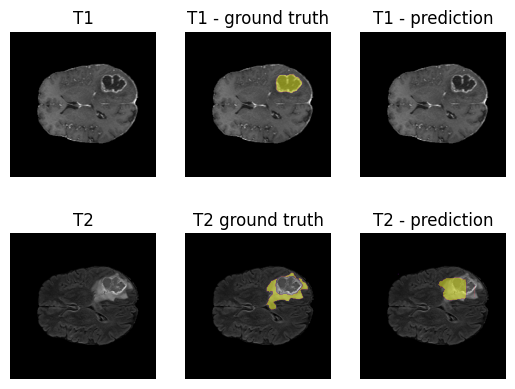

In [41]:
import matplotlib.pyplot as plt

def visualize(x, y, y_hat):
    """Overlay prediction and ground truth on images."""

    # overlay colormap
    colormap = "plasma"

    # T1 raw
    ax = plt.subplot(2,3,1)
    plt.imshow(np.array(x)[:,:,0].astype(np.uint8), "gray")
    ax.set_title("T1")
    plt.axis("off")

    # T2 raw
    ax = plt.subplot(2,3,4)
    plt.imshow(np.array(x)[:,:,1].astype(np.uint8), "gray")
    ax.set_title("T2")
    plt.axis("off")

    # T1 ground truth
    ax = plt.subplot(2,3,2)
    plt.imshow(np.array(x)[:,:,0].astype(np.uint8), "gray")
    max_val = np.max(np.array(y)[:,:,1])
    if max_val == 0:
        mask = np.zeros_like(np.array(y)[:,:,1])
    else:
        mask = np.array(y)[:,:,1] / max_val
    alpha_values = 0.5 * mask
    alpha_values = np.clip(alpha_values, 0, 1)
    plt.imshow(mask, colormap, alpha=alpha_values)
    ax.set_title("T1 - ground truth")
    plt.axis("off")


    # T2 ground truth
    ax = plt.subplot(2,3,5)
    plt.imshow(np.array(x)[:,:,1].astype(np.uint8), "gray")
    mask = np.array(y)[:,:,2]/np.max(np.array(y)[:,:,2])
    plt.imshow(mask, colormap, alpha=0.5*mask)
    ax.set_title("T2 ground truth")
    plt.axis("off")

    # T1 prediction
    ax = plt.subplot(2,3,3)
    plt.imshow(np.array(x)[:,:,0].astype(np.uint8), "gray")
    mask = np.argmax(y_hat, axis=-1) == 1
    plt.imshow(mask, colormap, alpha=0.5*mask)
    ax.set_title("T1 - prediction")
    plt.axis("off")

    # T2 prediction
    ax = plt.subplot(2,3,6)
    plt.imshow(np.array(x)[:,:,1].astype(np.uint8), "gray")
    mask = np.argmax(y_hat, axis=-1) == 2
    plt.imshow(mask, colormap, alpha=0.5*mask)
    ax.set_title("T2 - prediction")
    plt.axis("off")

# show one result
x, y = list(train.unbatch().take(1))[0]
y_hat = model(np.array([x]))[0] # add batch dim to input, remove batch dim from output
visualize(x, y, y_hat)

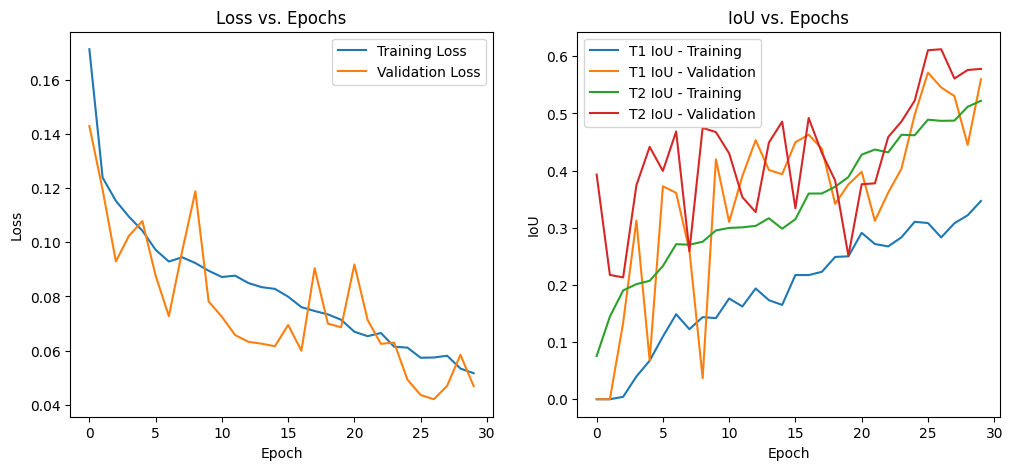

In [42]:
plt.figure(figsize=(12, 5))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs. Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

# Plot training & validation IoU values
plt.subplot(1, 2, 2)
plt.plot(history.history['t1_iou'], label='T1 IoU - Training')
plt.plot(history.history['val_t1_iou'], label='T1 IoU - Validation')
plt.plot(history.history['t2_iou'], label='T2 IoU - Training')
plt.plot(history.history['val_t2_iou'], label='T2 IoU - Validation')
plt.title('IoU vs. Epochs')
plt.ylabel('IoU')
plt.xlabel('Epoch')
plt.legend()

plt.show()
